### **Overview: The Stochastic Shortest Path Problem**

This notebook addresses the **Stochastic Shortest Path (SSP)** problem over a finite-state Markov decision process, where the goal is to compute an optimal policy $ \pi^\star $ minimizing the expected number of transitions from each initial state to a designated terminal state.

We consider a finite set of nodes $ \mathcal{X} = \{1, 2, \dots, n, t\} $, where $ t $ is the absorbing (termination) state. The system is controlled by inputs $ u \in \mathcal{U} = \{1, \dots, m\} $, and transitions occur according to a set of stochastic matrices $ P(u) \in \mathbb{R}^{(n+1) \times (n+1)} $, with each row summing to 1.

In this notebook, we will:
1. Generate random SSP problem data.
2. Solve the SSP problem using three methods:
   - Policy Iteration
   - Value Iteration
   - Linear Programming
3. Simulate the SSP process and validate the optimal policy.



<br>

#### **Step 0: Import Libraries and Set Seed**

We begin by importing the required Python libraries for numerical computation, optimization, and visualization.

To ensure reproducibility of all random results (e.g., transition matrices, simulations), we also fix the random seed.


In [ ]:
# =========================================
# STEP 0: Import Required Libraries and Utilities
# =========================================
import numpy as np
import time
import matplotlib.pyplot as plt
from ssp_utils import (
    generate_problem_data,
    plot_transition_matrix,
    SSPPolicyIteration,
    SSPValueIteration,
    SSPLinearProgram,
    simulate_ssp
)

# For reproducibility
np.random.seed(42)


<br>

#### **Step 1: Generate Random SSP Problem**

We begin by generating random problem data $ P(i, j, u) $, which encodes the probability of transitioning from state $ i $ to state $ j $ under action $ u $. The terminal state is absorbing, meaning once it is reached, no further transitions occur.

The structure of the probabilities ensures that transitions to nearby states are more likely than to distant ones.

In [ ]:
# =========================================
# STEP 1: Generate Problem Data (P tensor)
# =========================================
N = 100        # Number of states, NOT including the termination state which is N+1
M = 100        # Number of control inputs
P = generate_problem_data(N=N, M=M, SCALE_EXPONENT=2, seed=42)

<br>

#### **Step 2: Visualize Transition Matrix**

To better understand the structure of our SSP problem, we visualize the transition probability matrix $ P(u) $ for a selected control input $ u $.


Stochastic Shortest Path Problem
>> 101 discrete states
>> 100 discrete inputs


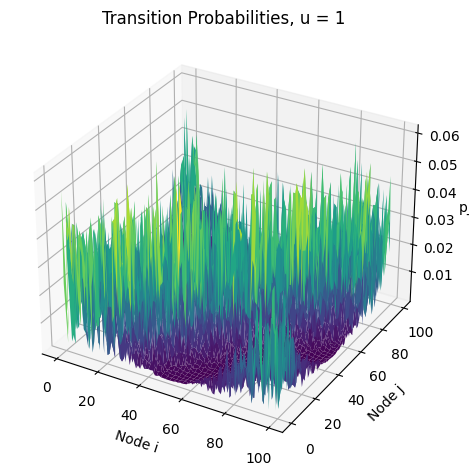

In [ ]:
# =========================================
# STEP 2: Visualize Transition Matrix for u = 1
# =========================================

# Get problem size
n = P.shape[0] - 1  # Number of non-terminal states
m = P.shape[2]      # Number of control inputs

# Display problem info
print(f"Stochastic Shortest Path Problem\n>> {n + 1} discrete states\n>> {m} discrete inputs")

# === Sanity check: All entries in P should be in [0, 1]
min_val = np.min(P)
max_val = np.max(P)
if min_val < 0 or max_val > 1:
    raise ValueError("Entries in P are not in [0,1].")

# === Sanity check: Terminal state condition
# p_tt = 1, p_tx = 0 for any x ≠ t
if not (np.all(P[n, 0:n, :] == 0) and np.all(P[n, n, :] == 1)):
    raise ValueError("Terminal state conditions are not satisfied.")

# Plot the transition matrix under the first control input
plot_transition_matrix(P, u=0)


<br>

#### **Step 3: Solve using Policy Iteration**

We now solve the SSP problem using the **Policy Iteration** method. This algorithm iteratively evaluates and improves the policy $ \pi $ until convergence to the optimal policy $ \pi^\star $.

The cost function being minimized is the expected number of transitions until absorption.


In [ ]:
# =========================================
# STEP 3: Solve using Policy Iteration
# =========================================
# Solve the stochastic shortest path (SSP) problem using policy iteration.
# Goal: Minimize the expected number of transitions from a given initial node
#       to the terminal (absorbing) state.
#
# Input:
#   - P: Transition probability tensor
# Output:
#   - J_policy: Optimal cost-to-go from each node
#   - F_policy: Optimal control action at each node

print("Solution Method 1: Policy Iteration")
print("Solving the stochastic shortest path (SSP) problem using policy iteration...")

start_time = time.time()

policy_solver = SSPPolicyIteration(P)
J_policy, F_policy = policy_solver.solve()

print(f"Execution time: {time.time() - start_time:.5f}s.")


Solution Method 1: Policy Iteration
Solving the stochastic shortest path (SSP) problem using policy iteration...
Policy Iteration Number 1
Policy Iteration Number 2
Policy Iteration Number 3
Policy Iteration Number 4
Policy iteration converged.
Execution time: 0.04507s.


<br>

#### **Step 4: Solve using Value Iteration**

As an alternative to policy iteration, we solve the SSP problem using **Value Iteration**. This method iteratively updates the value function $ J $ until convergence. The result from Policy Iteration can be used to set a meaningful stopping criterion (tolerance $ \epsilon $).


In [ ]:
# =========================================
# STEP 4: Solve using Value Iteration
# =========================================
# Solve the stochastic shortest path (SSP) problem using value iteration.
# Goal: Minimize the expected number of transitions from a given initial node
#       to the terminal (absorbing) state.
#
# Notes:
# - Uses a convergence threshold (epsilon) to determine stopping.
# - A good epsilon can be informed by the result from policy iteration (Step 4).
#
# Input:
#   - P: Transition probability tensor
# Output:
#   - J_value: Optimal cost-to-go from each node
#   - F_value: Optimal control action at each node

print("Solution Method 2: Value Iteration")
print("Solving the stochastic shortest path (SSP) problem using value iteration...")

start_time = time.time()

value_solver = SSPValueIteration(P)
J_value, F_value = value_solver.solve(epsilon=0.1)

print(f"Execution time: {time.time() - start_time:.5f}s.")


Solution Method 2: Value Iteration
Solving the stochastic shortest path (SSP) problem using value iteration...
Value Iteration Number 1
Value Iteration Number 2
Value Iteration Number 3
Value Iteration Number 4
Value Iteration Number 5
Value Iteration Number 6
Value Iteration Number 7
Value Iteration Number 8
Value Iteration Number 9
Value Iteration Number 10
Value Iteration Number 11
Value Iteration Number 12
Value Iteration Number 13
Value Iteration Number 14
Value Iteration Number 15
Value Iteration Number 16
Value Iteration Number 17
Value Iteration Number 18
Value Iteration Number 19
Value Iteration Number 20
Value Iteration Number 21
Value Iteration Number 22
Value Iteration Number 23
Value Iteration Number 24
Value Iteration Number 25
Value Iteration Number 26
Value Iteration Number 27
Value Iteration Number 28
Value Iteration Number 29
Value Iteration Number 30
Value Iteration Number 31
Value Iteration Number 32
Value Iteration Number 33
Value Iteration Number 34
Value Iteratio

<br>

#### **Step 5: Solve using Linear Programming**

We formulate the SSP problem as a **Linear Program (LP)** to solve for the optimal cost-to-go \( J^\star \). The policy \( \pi^\star \) is then recovered by selecting the action that minimizes the expected cost at each state.


In [ ]:
# =========================================
# STEP 5: Solve using Linear Programming
# =========================================
# Solve the stochastic shortest path (SSP) problem using linear programming.
# Goal: Minimize the expected number of transitions from a given initial node
#       to the terminal (absorbing) state.
#
# Notes:
# - This method reformulates the SSP problem as a linear program.
# - The LP minimizes the total expected cost under linear inequality constraints.
#
# Input:
#   - P: Transition probability tensor
# Output:
#   - J_lp: Optimal cost-to-go from each node
#   - F_lp: Optimal control action at each node (post-recovered from J_lp)

print("Solution Method 3: Linear Programming")
print("Solving the stochastic shortest path (SSP) problem using linear programming...")

start_time = time.time()

lp_solver = SSPLinearProgram(P)
J_lp, F_lp = lp_solver.solve()

print(f"Execution time: {time.time() - start_time:.5f}s.")


Solution Method 3: Linear Programming
Solving the stochastic shortest path (SSP) problem using linear programming...
Execution time: 1.56071s.


<br>

#### **Step 6: Compare Cost-to-Go Estimates from All Methods**

We now compare the **optimal cost-to-go functions** $ J^\star $ obtained using:
- Policy Iteration
- Value Iteration
- Linear Programming

For each state $ i \in \mathcal{X} \setminus \{t\} $, we plot the expected number of transitions required to reach the terminal state under the respective optimal policy $ \pi^\star $.

This visualization confirms that all three methods yield consistent optimal costs.



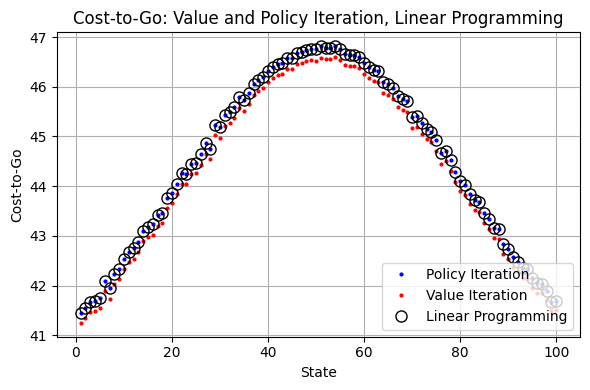

In [ ]:
# =========================================
# STEP 6: Compare Cost-to-Go from All Methods
# =========================================

plt.figure(figsize=(6, 4))
states = np.arange(1, n + 1 + 1)  # states 1 to n (MATLAB 1-indexing)

plt.plot(states[:-1], J_policy[:n], 'b.', markersize=4, label='Policy Iteration')
plt.plot(states[:-1], J_value[:n], 'r.', markersize=4, label='Value Iteration')
plt.plot(states[:-1], J_lp[:n], 'ko', markersize=8, markerfacecolor='none', label='Linear Programming')

plt.xlabel('State')
plt.ylabel('Cost-to-Go')
plt.title('Cost-to-Go: Value and Policy Iteration, Linear Programming')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


<br>

#### **Step 7: Visualize Optimal Policy from Policy Iteration**

Here we visualize the **optimal control action** $ \pi^\star(i) $ at each state $ i \in \mathcal{X} \setminus \{t\} $, as computed by the Policy Iteration method.

Each bar indicates which control input is selected by the optimal policy $ \pi^\star $ at the corresponding state.


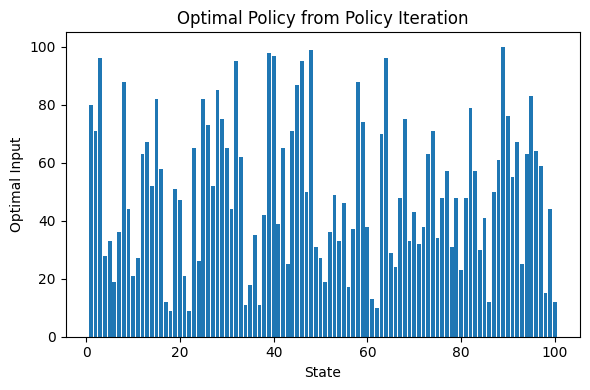

In [ ]:
# =========================================
# STEP 7: Plot Optimal Policy from Policy Iteration
# =========================================

plt.figure(figsize=(6, 4))
plt.bar(states[:-1], F_policy[:n])
plt.xlabel('State')
plt.ylabel('Optimal Input')
plt.title('Optimal Policy from Policy Iteration')
plt.tight_layout()
plt.show()

<br>

#### **Step 8: Simulate SSP and Analyze Performance**

To validate the computed policy $ \pi^\star $, we simulate the SSP process multiple times starting from a fixed node $ i_0 \in \mathcal{X} $.

We compute the empirical mean and standard deviation of the total cost (i.e., number of steps until termination), and compare them with the theoretical values obtained from the three solution methods.



Simulate Problem
Running 1000 simulations from node 50...

SIMULATION
Starting node 50
Simulated average cost           : 46.9630
Simulated cost standard deviation: 43.4591
Expected minimum cost (policy iteration) : 46.8114
Expected minimum cost (value iteration)  : 46.5883
Expected minimum cost (linear programming): 46.8114
--------------------------------------------------------------


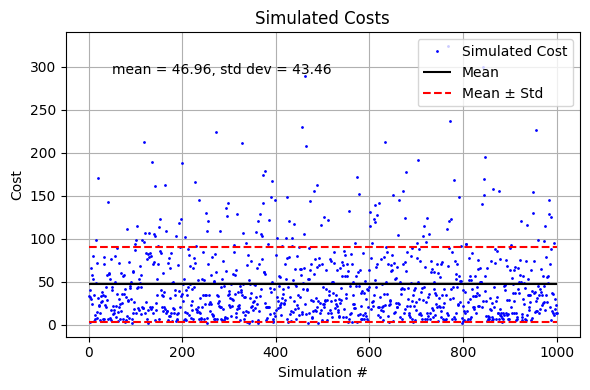

In [ ]:
# =========================================
# STEP 8: Simulate SSP and Analyze Statistics
# =========================================
# Simulate the stochastic shortest path (SSP) system using the optimal policy
# obtained from Policy Iteration (Method 1). Perform multiple runs from a fixed
# starting state and analyze the resulting cost distribution.
#
# Purpose:
# - Validate the policy via Monte Carlo simulations.
# - Compare empirical cost statistics with theoretical expectations.
#
# Inputs:
#   - P: Transition probability tensor
#   - F_policy: Optimal policy obtained from policy iteration
#   - i0: Initial state to start all simulations from (center of grid)
#   - SIM_NUM: Number of simulation runs
#
# Outputs:
#   - sim_costs: Vector of total cost in each simulation
#   - avgCost: Mean of simulation costs
#   - stdCost: Standard deviation of simulation costs

# Number of simulations to estimate statistics
SIM_NUM = 1000

# Start from the center of the wrap-around grid
i0 = n // 2

print("\nSimulate Problem")
print(f"Running {SIM_NUM} simulations from node {i0}...")

# Run simulations under policy iteration's optimal policy
sim_costs = simulate_ssp(P, i0, SIM_NUM, F_policy)

# Compute statistics
avgCost = np.mean(sim_costs)
stdCost = np.std(sim_costs)

# Display comparison between simulation and theoretical expectations
print("\nSIMULATION")
print(f"Starting node {i0}")
print(f"Simulated average cost           : {avgCost:.4f}")
print(f"Simulated cost standard deviation: {stdCost:.4f}")
print(f"Expected minimum cost (policy iteration) : {J_policy[i0]:.4f}")
print(f"Expected minimum cost (value iteration)  : {J_value[i0]:.4f}")
print(f"Expected minimum cost (linear programming): {J_lp[i0]:.4f}")
print("--------------------------------------------------------------")

# Plot simulation results
plt.figure(figsize=(6, 4))
plt.plot(range(1, SIM_NUM + 1), sim_costs, 'b.', markersize=2, label='Simulated Cost')

# Overlay mean and ±std lines
plt.hlines(avgCost, 1, SIM_NUM, colors='k', linestyles='-', label='Mean')
plt.hlines([avgCost - stdCost, avgCost + stdCost], 1, SIM_NUM, colors='r', linestyles='--', label='Mean ± Std')

# Annotate mean and std
annotation_text = f"mean = {avgCost:.2f}, std dev = {stdCost:.2f}"
plt.text(0.05 * SIM_NUM, max(sim_costs) * 0.9, annotation_text)

plt.xlabel('Simulation #')
plt.ylabel('Cost')
plt.title('Simulated Costs')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

